|       | Description |
| ----------- | ----------- |
| Author      | Honglin Qian (MSFE student at UIUC)|
| Date   | 01/31/2024        |
|Email|honglin6@illinois.edu|
|Idea| Use fitted SSVI parameters from SPX index for inference |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
combined_df = pd.read_csv('./clean_data2023.csv')
# combined_df = combined_df.dropna(subset=['P_IV'])
#combined_df = combined_df[ (combined_df['QUOTE_DATE'] == '2023-01-04') & (combined_df['DTE'] >1000) ]
combined_df = combined_df.dropna(subset=['STRIKE'])
combined_df = combined_df.dropna(subset=['UNDERLYING_LAST'])
combined_df = combined_df.dropna(subset=['DTE'])
combined_df = combined_df[combined_df['DTE'] != 0]


k = combined_df['Log-Strike']
T = combined_df['DTE']/365

# SSVI parameters
# params = [-0.5,  1.19,  0.49,    0.04,  0.04,  0.11] #paper
# params = -0.65123362,  0.41200321,  0.74083532, 0.03897386, 0.03987186, 0.10999981,  #paper
# params = [-0.72669427,  1.1998262, 0.5, 1.355e-02,  3.302e-02,  1.100e-01]
# params = [-0.72669427,  1.1998262,   0.5, 1.355e-02,  3.302e-02,  1.100e-01]
params = [-0.69153156, 1.32889811, 0.5,2.693e-02, 3.732e-02, 1.100e-01]



kappa1 = 5.5
kappa2 = 0.1

rho, eta, gamma, V, V_prime, theta = params
# Function for the SSVI implied volatility

def w(rho, eta, gamma, V, V_prime, theta, k, T):
    theta_T = theta * T + (V - theta) * (1-np.exp(-kappa1 * T)) / kappa1 + (V_prime - theta) * kappa1 * ((1-np.exp(-kappa2 * T)) / kappa2 - (1-np.exp(-kappa1 * T)) / kappa1 ) / (kappa1 - kappa2)
    phi_theta_T = eta / (theta_T ** gamma)
    ssvi_total_variance = (theta_T / 2) * (1 + rho * phi_theta_T * k + np.sqrt((phi_theta_T * k + rho) ** 2 + (1 - rho ** 2)))
    return ssvi_total_variance
    
def d_w_d_T(rho, eta, gamma, V, V_prime, theta, k, T):
    theta_T = theta * T + (V - theta) * (1-np.exp(-kappa1 * T)) / kappa1 + (V_prime - theta) * kappa1 * ((1-np.exp(-kappa2 * T)) / kappa2 - (1-np.exp(-kappa1 * T)) / kappa1 ) / (kappa1 - kappa2)
    phi_theta_T = eta / (theta_T ** gamma)
    d_theta_t_dT = theta + (V - theta)*np.exp(-kappa1*T) + (V_prime - theta) * (kappa1/(kappa1-kappa2)) * (np.exp(-kappa2*T)-np.exp(-kappa1*T))
    first_term = 0.5*(1 + rho*phi_theta_T*k + np.sqrt((phi_theta_T*k + rho)**2 + (1-rho**2)))
    second_term = -rho*eta*gamma*theta_T**(-gamma-1)*k + (-(phi_theta_T * k + rho)*eta*gamma * theta_T**(-gamma-1)*k / np.sqrt((phi_theta_T*k+rho)**2 + (1-rho**2)))
    dwdt = d_theta_t_dT * (0.5 * first_term + 0.5 * theta_T * second_term)
    return dwdt


def d_w_d_k(rho, eta, gamma, V, V_prime, theta, k, T):
    theta_T = theta * T + (V - theta) * (1-np.exp(-kappa1 * T)) / kappa1 + (V_prime - theta) * kappa1 * ((1-np.exp(-kappa2 * T)) / kappa2 - (1-np.exp(-kappa1 * T)) / kappa1 ) / (kappa1 - kappa2)
    phi_theta_T = eta / (theta_T ** gamma)
    dwdk = 0.5 * theta_T * (rho*phi_theta_T+ ((phi_theta_T * k + rho)*phi_theta_T)/(np.sqrt((phi_theta_T*k+rho)**2 + (1-rho**2))))
    return dwdk

def d2w_dk2(rho, eta, gamma, V, V_prime, theta, k, T):
    theta_T = theta * T + (V - theta) * (1-np.exp(-kappa1 * T)) / kappa1 + (V_prime - theta) * kappa1 * ((1-np.exp(-kappa2 * T)) / kappa2 - (1-np.exp(-kappa1 * T)) / kappa1 ) / (kappa1 - kappa2)
    phi_theta_T = eta / (theta_T ** gamma)
    sol = 0.5 * theta_T * ((phi_theta_T**2 * (1-rho**2))/(((phi_theta_T * k + rho)**2 + (1-rho**2))**(3/2)))
    return sol


def local_vol(rho, eta, gamma, V, V_prime, theta, k, T):
    ans = d_w_d_T(rho, eta, gamma, V, V_prime, theta, k, T)/(((k/(2*w(rho, eta, gamma, V, V_prime, theta, k, T)))*(d_w_d_k(rho, eta, gamma, V, V_prime, theta, k, T))-1)**2 + 0.5* d2w_dk2(rho, eta, gamma, V, V_prime, theta, k, T) - 0.25*(0.25+1/w(rho, eta, gamma, V, V_prime, theta, k, T))*(d_w_d_k(rho, eta, gamma, V, V_prime, theta, k, T))**2)
    return np.sqrt(ans)

In [3]:
combined_df

,QUOTE_DATE,EXPIRE_DATE,DTE,UNDERLYING_LAST,STRIKE,P_BID,P_ASK,P_IV,C_BID,C_ASK,C_IV,P_price,C_price,rf,Log-Strike,div
144,2023-01-04,2023-01-05,1.00,3853.39,1000.0,0.0,0.05,5.41271,2848.4,2855.0,NaN,0.025,2851.70,0.042000,-1.349068,0.0171
145,2023-01-04,2023-01-05,1.00,3853.39,1200.0,0.0,0.05,4.69153,2648.4,2655.0,NaN,0.025,2651.70,0.042000,-1.166747,0.0171
146,2023-01-04,2023-01-05,1.00,3853.39,1400.0,0.0,0.05,4.08850,2453.1,2454.7,12.77327,0.025,2453.90,0.042000,-1.012596,0.0171
147,2023-01-04,2023-01-05,1.00,3853.39,1600.0,0.0,0.05,3.56491,2248.5,2254.6,NaN,0.025,2251.55,0.042000,-0.879065,0.0171
148,2023-01-04,2023-01-05,1.00,3853.39,1800.0,0.0,0.05,3.10337,2046.3,2051.5,NaN,0.025,2048.90,0.042000,-0.761282,0.0171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453005,2023-09-29,2028-12-15,1904.04,4286.60,8800.0,2880.7,3072.60,NaN,6.3,48.4,0.13139,2976.650,27.35,0.045752,0.480588,0.0156
1453006,2023-09-29,2028-12-15,1904.04,4286.60,9200.0,3186.3,3378.20,NaN,5.0,39.1,0.13457,3282.250,22.05,0.045752,0.525040,0.0156
1453007,2023-09-29,2028-12-15,1904.04,4286.60,9600.0,3494.7,3686.60,NaN,5.0,32.7,0.13909,3590.650,18.85,0.045752,0.567600,0.0156
1453008,2023-09-29,2028-12-15,1904.04,4286.60,10000.0,3805.0,3996.90,NaN,3.1,22.3,0.13708,3900.950,12.70,0.045752,0.608422,0.0156


In [18]:
pip install ipympl

Note: you may need to restart the kernel to use updated packages.


In [4]:
%matplotlib widget

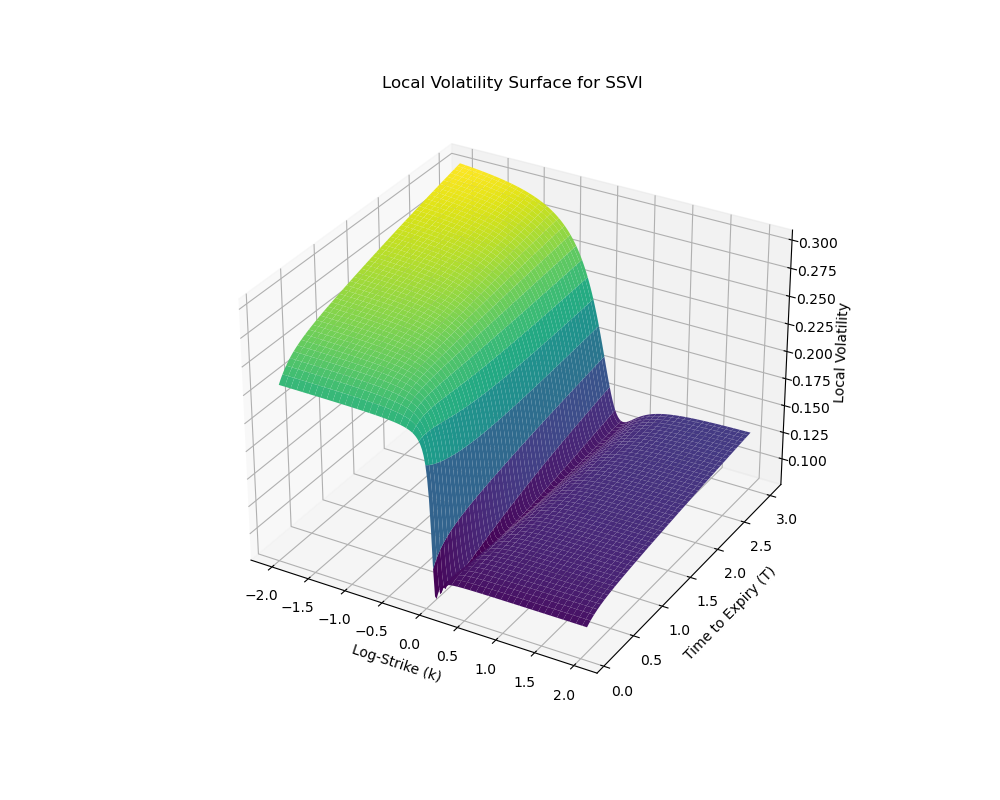

In [5]:

k_range = np.linspace(-2, 2, 200)  # Adjust the range and number of points as needed
T_range = np.linspace(0.1, 3, 200)  # Adjust the range and number of points as needed

K, T = np.meshgrid(k_range, T_range)
#K, T = np.meshgrid(k, T)
LV = np.zeros_like(K)

# Calculate local volatility for each (k, T) pair
for i in range(K.shape[0]):
    for j in range(K.shape[1]):
        LV[i, j] = local_vol(rho, eta, gamma, V, V_prime, theta, K[i, j], T[i, j])

# Plotting the local volatility
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K, T, LV, cmap='viridis')

ax.set_xlabel('Log-Strike (k)')
ax.set_ylabel('Time to Expiry (T)')
ax.set_zlabel('Local Volatility')
plt.title('Local Volatility Surface for SSVI')

plt.show()

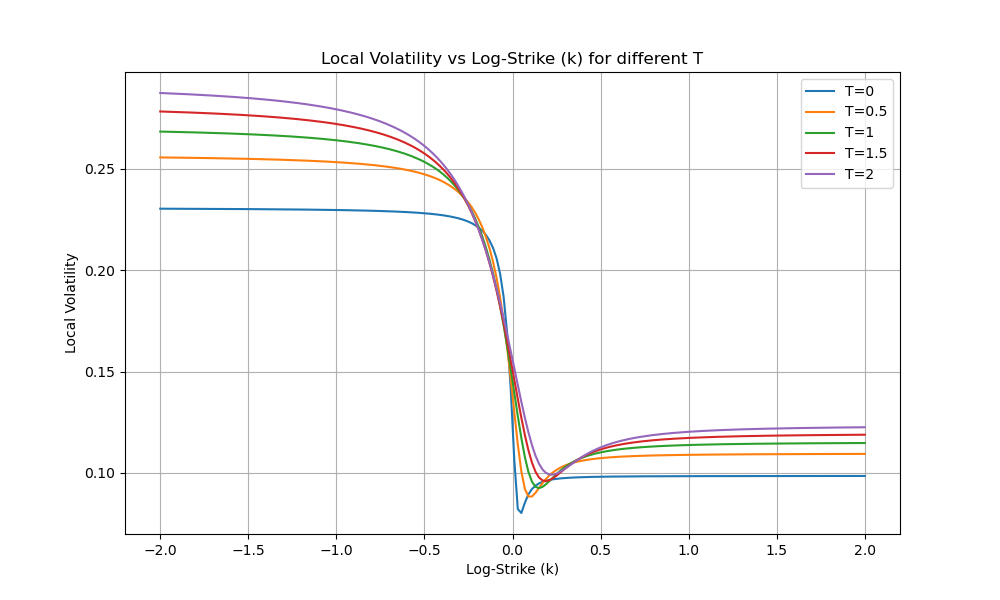

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming rho, eta, gamma, V, V_prime, theta are defined
# and your local_vol function is correctly implemented

# Your existing code to compute LV
k_range = np.linspace(-2, 2, 200)  # Adjust the range and number of points as needed
T_range = np.linspace(0.1, 3, 200)  # Adjust the range and number of points as needed

K, T = np.meshgrid(k_range, T_range)



#K, T = np.meshgrid(k, T)
LV = np.zeros_like(K)

for i in range(K.shape[0]):
    for j in range(K.shape[1]):
        LV[i, j] = local_vol(rho, eta, gamma, V, V_prime, theta, K[i, j], T[i, j])

# Choose fixed T values for 2D plots, e.g., T=0.5, 1, 2
fixed_T_values = [0, 0.5, 1, 1.5, 2]

# Create a single figure for all plots
plt.figure(figsize=(10, 6))

# Plotting 2D plots for each fixed T in the same figure
for fixed_T in fixed_T_values:
    # Find the index in T_range that is closest to the desired fixed T value
    T_index = np.argmin(np.abs(T_range - fixed_T))
    
    # Extract the local volatility slice for the fixed T
    LV_slice = LV[T_index, :]
    
    # Plotting on the same figure
    plt.plot(k_range, LV_slice, label=f'T={fixed_T}')

# Finalizing the plot
plt.xlabel('Log-Strike (k)')
plt.ylabel('Local Volatility')
plt.title('Local Volatility vs Log-Strike (k) for different T')
plt.legend()
plt.grid(True)

plt.show()


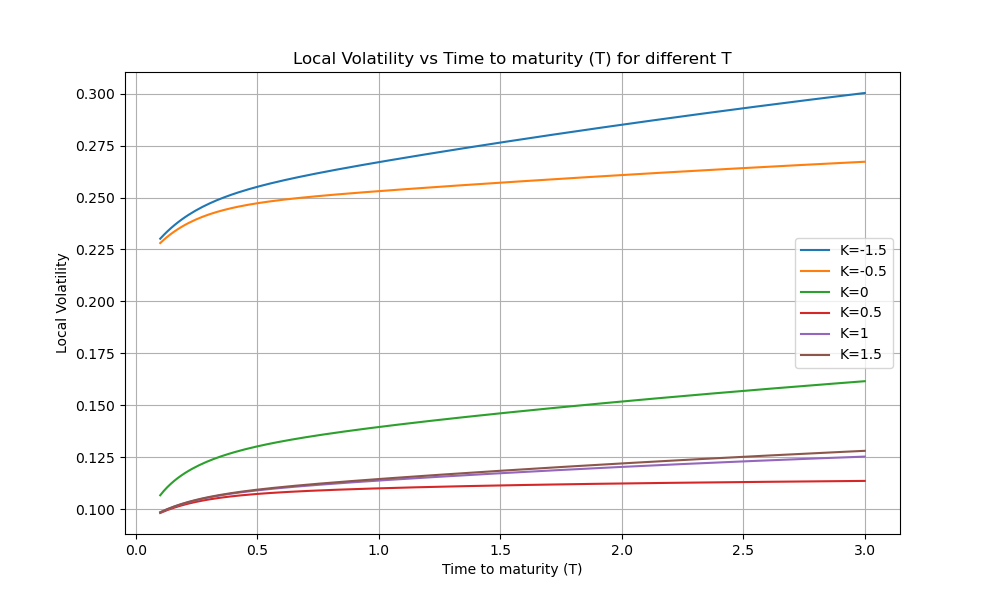

In [7]:
LV = np.zeros_like(T)

for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        LV[i, j] = local_vol(rho, eta, gamma, V, V_prime, theta, K[i, j], T[i, j])

# Choose fixed T values for 2D plots, e.g., T=0.5, 1, 2
fixed_K_values = [-1.5, -0.5, 0, 0.5, 1, 1.5]

# Create a single figure for all plots
plt.figure(figsize=(10, 6))

# Plotting 2D plots for each fixed T in the same figure
for fixed_K in fixed_K_values:
    # Find the index in T_range that is closest to the desired fixed T value
    K_index = np.argmin(np.abs(k_range - fixed_K))
    
    # Extract the local volatility slice for the fixed T
    LV_slice = LV[:,K_index]
    
    # Plotting on the same figure
    plt.plot(T_range, LV_slice, label=f'K={fixed_K}')

# Finalizing the plot
plt.xlabel('Time to maturity (T)')
plt.ylabel('Local Volatility')
plt.title('Local Volatility vs Time to maturity (T) for different T')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
LV

array([[0.23038209, 0.23037609, 0.23036995, ..., 0.09850847, 0.09850921,
        0.09850994],
       [0.23220634, 0.23219973, 0.23219297, ..., 0.09929528, 0.09929612,
        0.09929693],
       [0.23390544, 0.23389824, 0.23389086, ..., 0.10002794, 0.10002887,
        0.10002978],
       ...,
       [0.30365001, 0.30354199, 0.30343138, ..., 0.12883942, 0.12886666,
        0.12889311],
       [0.30387604, 0.30376746, 0.30365627, ..., 0.12892558, 0.12895299,
        0.12897961],
       [0.30410164, 0.3039925 , 0.30388074, ..., 0.12901151, 0.1290391 ,
        0.12906589]])

In [9]:
LV.shape

(200, 200)

# Black Scholes

In [40]:
# Function for Black-Scholes price (unchanged)
from scipy.stats import norm

def black_scholes_call_with_dividends(S, K, T, r, q, sigma):
    """
    Calculate the price of a European call option using the Black-Scholes formula, considering dividends.
    
    Parameters:
    - S: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - q: Dividend yield
    - sigma: Volatility of the underlying asset
    
    Returns:
    - call_price: Price of the European call option
    """
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * np.exp(-q * T) * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0)
    return call_price


# Assuming LV is your provided local volatility matrix; ensure its shape matches your simulation setup
# LV = <Your LV Array Here>

# Parameters for the option
S0 = 3853.39  # Initial price of the underlying asset
K = 1000   # Strike price
T = 1/365     # Time to maturity, in years
r = 0.042  # Risk-free interest rate
q = 0.0171 # dividend

# Black-Scholes pricing with constant volatility
constant_vol = np.mean(LV)

bs_price = black_scholes_call_with_dividends(S0, K, T, r, q, constant_vol)

print(f"Black-Scholes Call Price with Constant Volatility: {bs_price}")


Black-Scholes Call Price with Constant Volatility: 2853.3245374195903
